In [21]:
import numpy  as np 
import pandas as pd 
import os
import cv2 
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix

import keras
from keras.preprocessing import image
from keras.models import Model
from keras.applications import DenseNet121
from keras.layers import GlobalAveragePooling2D, Input, Dropout, Flatten, Dense, BatchNormalization
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.activations import softmax, relu, sigmoid
from keras.optimizers import Adam

# Global constants
IMG_DIM      = 256
BATCH_SIZE   = 32
CHANNEL_SIZE = 3
NUM_CLASSES  = 5

class_names = {"0":"No DR", "1":"Mild", "2":"Moderate", "3":"Severe", "4":"Proliferative DR"}

# data frame of current competition
df_2019 = pd.read_csv(f"../aptos2019/train.csv") 
df_2019.id_code = df_2019.id_code.apply(lambda x: x + ".png")
df_2019.id_code = df_2019.id_code.apply(lambda x: "modified_" + x) 
train_2019, valid_2019 = train_test_split(df_2019, test_size=0.2, shuffle=False)

# 2019 data frame 
df_2015 = pd.read_csv(f"../aptos2015/trainLabels.csv") 
df_2015.image   = df_2015.image.apply(lambda   x: x + ".jpeg")
df_2015["id_code"]   = df_2015.image
df_2015["diagnosis"] = df_2015.level
train_2015, valid_2015 = train_test_split(df_2015, test_size=0.2, shuffle=False)

# valid_2019['diagnosis'].value_counts().plot(kind='bar')
# plt.title('Samples Per Class')

# Loading data

In this kernel, we are using multilabel data. Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. 

The idea is that if an eye has severe diabetic retinopathy, that also means that it has moderate and severe diabetic retinopathy

2370
                        id_code diagnosis           labels
3166  modified_dbb2c63f6f08.png         3     [0, 1, 2, 3]
2938  modified_cbd0870aa933.png         4  [0, 1, 2, 3, 4]
2970  modified_ce207b69ff37.png         3     [0, 1, 2, 3]
3181  modified_dd285d9e97fe.png         0              [0]
3494  modified_f36cb007a1ef.png         0              [0]


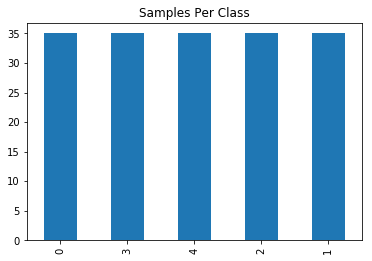

In [2]:

def label_convert(y_val):
    y_val = y_val.astype(int).sum(axis=1) - 1
    #y_val= np.argmax(y_val, axis=1)
    return y_val

def get_train_valid_df(year="2019", even_distrib=True):
    
    # shuffle data so each time different samples are dropped
    if (year == "2019"):
        train = train_2019.sample(frac=1)
        valid = valid_2019.sample(frac=1)
    elif (year == "2015"):
        train = train_2015.sample(frac=1)
        valid = valid_2015.sample(frac=1)
    
    # remap from classes to smoothed version of the classes
    train["labels"] = train.diagnosis.apply(lambda x: [i for i in range(x + 1)])
    valid["labels"] = valid.diagnosis.apply(lambda x: [i for i in range(x + 1)])

    train.diagnosis = train.diagnosis.astype('str')
    valid.diagnosis = valid.diagnosis.astype('str')

    # drop classes 
    if even_distrib:
        min_train = min(train['diagnosis'].value_counts())
        min_valid = min(valid['diagnosis'].value_counts())

        for diagnosis in range(5):
            indexes_valid = valid[valid['diagnosis'] == str(diagnosis)].index
            indexes_train = train[train['diagnosis'] == str(diagnosis)].index
            
            frac_drop_train = indexes_train.size * (1 - min_train/indexes_train.size)
            frac_drop_valid = indexes_valid.size * (1 - min_valid/indexes_valid.size)
            
            train.drop(indexes_train[:int(frac_drop_train)], inplace=True)
            valid.drop(indexes_valid[:int(frac_drop_valid)], inplace=True)

    # shuffle it for even distribution later, and take a smaller batch if the train size is larger than 10000
    frac = 1
    print(train.size)
    if train.size > 10000:
        frac = 10000/train.size
    train = train.sample(frac=frac)
    valid = valid.sample(frac=frac)
    
    return train, valid

# plot example
_, df_to_plot = get_train_valid_df(year="2019")
df_to_plot['diagnosis'].value_counts().plot(kind='bar')
plt.title('Samples Per Class')
print(df_to_plot.head(5))

# df_to_plot.columns

In [3]:
# display some data
# df_example, _ = get_train_valid_df(year="2019")

# # Display some random images from Data Set with class categories.
# figure=plt.figure(figsize=(22,20))
# for target_class in (df_example['diagnosis'].unique()):
#     for i, (idx, row ) in enumerate(df_example.loc[df_example.diagnosis == target_class]
#                                     .sample(4)
#                                     .iterrows()):
#         # open the file
#         imagefile = f"../aptos2019/train_images/{row['id_code']}" 
#         img = cv2.imread(imagefile)
        
#         # original version
#         rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         ax = figure.add_subplot(5,4, int(target_class)*4+i+1)
#         plt.imshow(rgb)
#         ax.set_title(class_names[target_class])
        

In [14]:
# Data generators, which put their data into a random crop generator, which is then fed into
# the network during training

def dataGenerator(jitter=0.1):
    datagen = image.ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True, 
                                       vertical_flip=True,
                                       rotation_range=int(800*jitter),
                                       brightness_range=[1-jitter, 1+jitter],
                                       channel_shift_range=int(20*jitter),
                                       zoom_range=[(1-jitter), (1+jitter/2)],
                                       fill_mode="reflect",
                                      )
    return datagen

def datagen_with_flow(datagen, dataframe, directory):
    return datagen.flow_from_dataframe(dataframe=dataframe, directory=directory,
                                       x_col="id_code", 
                                       y_col='labels', 
                                       class_mode="categorical", 
                                       batch_size=BATCH_SIZE,
                                       target_size=(IMG_DIM, IMG_DIM),
                                       shuffle=False,
                                      )

def generator(jitter=0.1, year="2019", even_distrib=True):
    
    train, valid = get_train_valid_df(year=year, even_distrib=even_distrib) 
    datagen = dataGenerator(jitter)
    
    train_gen = datagen_with_flow(datagen, train, f"../aptos{year}/train_images/")
    valid_gen = datagen_with_flow(datagen, valid, f"../aptos{year}/train_images/")
    
    return train_gen, valid_gen

gc.collect()


1309

In [5]:
# train_sample_gen, valid_sample_gen = generator(jitter=0.05)

# # Display some data generation
# figure=plt.figure(figsize=(22,20))
# for batch in valid_sample_gen:
#     for j in range(16):
#         ax = figure.add_subplot(4,4, j+1)
#         batch[0][j] = np.clip(batch[0][j], 0, 1)
#         plt.imshow(batch[0][j])
#     break

In [28]:
class Metrics(Callback):
    def __init__(self, generator):
        self.generator = generator
        
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        
        numBatches = 15
        y_pred = []
        y_val = []
        for x, y in self.generator:
            predictions = model.predict(x) 
            predictions = predictions > 0.5
            y_pred.extend(label_convert(predictions))
            y_val.extend(label_convert(y))
            
            numBatches -= 1
            if numBatches <= 0:
                break
            
        val_kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')
        self.val_kappas.append(val_kappa)
        
        print(val_kappa)
        print(confusion_matrix(y_val, y_pred))
            
        if val_kappa == max(self.val_kappas) and val_kappa > 0.84:
            gc.collect()
            print("Max of this run, saving model.")
            model.save(f"dense-multi-{val_kappa:.4f}.h5")


In [29]:
def create_model(img_dim, channels, n_class):
    
    input_tensor = Input(shape=(img_dim, img_dim, channels))
    base_model   = DenseNet121(weights=None, include_top=False, input_tensor=input_tensor)
#     base_model.load_weights('../DenseNet-BC-121-32-no-top.h5')
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.2)(x)
    x = Dense(512, activation=relu)(x)
    x = Dropout(0.15)(x)
    x = BatchNormalization()(x)
    output_layer = Dense(n_class, activation='sigmoid', name="Output_Layer")(x)
    model = Model(input_tensor, output_layer)
    
    return model

model = create_model(IMG_DIM, CHANNEL_SIZE, NUM_CLASSES)
model.load_weights("dense-multi-0.8865.h5") 
model.save_weights("trial_save.h5") 



In [30]:
 for jitter in [0.2, 0.05]:
    
    model.compile(optimizer=Adam(lr=0.00005), loss=keras.losses.mean_squared_error,  metrics=['accuracy'])
    
    print("           -----------------------------------", jitter, "-----------------------------------")
    
    for even_distrib in [False, True]:
        
        for year in ["2019", "2015", "2019"]:

            print("           -   -   -   -   -   -   -   -   ", year, even_distrib, "-   -   -   -   -   -   -   -   -")
            # these need to be global for the kappa callback
            train_generator, valid_generator = generator(jitter=0.1, year=year, even_distrib=even_distrib)

            # Call backs during training            
            kappa_callbacks = Metrics(valid_generator)
            reduce_lr  = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, 
                                           min_lr=1e-8, mode='auto', verbose=1)

            # train the model for 12 epochs
            history = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=train_generator.n  // train_generator.batch_size,
                                          validation_data=valid_generator,
                                          validation_steps=valid_generator.n // valid_generator.batch_size,
                                          epochs=5,
                                          callbacks=[reduce_lr, kappa_callbacks],
                                          verbose=1
                                         )
    
    gc.collect()

           ----------------------------------- 0.2 -----------------------------------
           -   -   -   -   -   -   -   -    2019 False -   -   -   -   -   -   -   -   -
8787
Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.
Epoch 1/5
91/91 [==============================] - 181s 2s/step - loss: 0.0740 - acc: 0.5934 - val_loss: 0.0456 - val_acc: 0.5838
0.8865201439764823
[[250   2   0   0   1]
 [  4  17  19   1   1]
 [  3   5  88  14   9]
 [  0   0  13   9   6]
 [  0   0  10   5  20]]
Max of this run, saving model.
Epoch 2/5
91/91 [==============================] - 107s 1s/step - loss: 0.0551 - acc: 0.5574 - val_loss: 0.0427 - val_acc: 0.5749
0.8745548397423072
[[240   2   1   0   0]
 [  7  18  20   1   2]
 [  2  11  92   5   6]
 [  0   1  16   3   8]
 [  0   2  13   8  22]]
Epoch 3/5
91/91 [==============================] - 105s 1s/step - loss: 0.0488 - acc: 0.5436 - val_loss: 0.0356 - val_acc: 0.5802
0.89110

24/24 [==============================] - 32s 1s/step - loss: 0.1920 - acc: 0.7786 - val_loss: 0.1566 - val_acc: 0.5375
0.44881434355118566
[[90  0  0  0  0]
 [37 20 22  2  5]
 [20 12 53  2  6]
 [ 1  8 63  6 10]
 [18 14 48  3  6]]
Epoch 2/5
24/24 [==============================] - 27s 1s/step - loss: 0.2048 - acc: 0.7627 - val_loss: 0.1604 - val_acc: 0.5664
0.4352797260226958
[[88  0  0  0  0]
 [45 21 21  1  2]
 [25 12 42  2  8]
 [ 3  5 61  6 13]
 [25 11 44  3  8]]
Epoch 3/5
24/24 [==============================] - 27s 1s/step - loss: 0.2016 - acc: 0.7718 - val_loss: 0.1583 - val_acc: 0.5594
0.43926877953718824
[[88  0  0  0  0]
 [39 17 20  1  2]
 [28  9 41  6  5]
 [ 5 11 51  6 15]
 [20 14 41  1  9]]
Epoch 4/5
24/24 [==============================] - 27s 1s/step - loss: 0.1998 - acc: 0.7699 - val_loss: 0.1557 - val_acc: 0.5714
0.39665045357947526
[[87  0  0  0  0]
 [55 18 22  0  1]
 [25 12 40  3  6]
 [ 8  7 53  3 16]
 [31 11 38  1  9]]
Epoch 5/5
24/24 [==============================] - 

62/62 [==============================] - 71s 1s/step - loss: 0.1847 - acc: 0.7480 - val_loss: 0.2144 - val_acc: 0.8020
0.37550947267178525
[[ 83   1   0   0   0]
 [112   0   0   0   0]
 [ 76  12   7   0   0]
 [ 24  19  50   1   0]
 [ 20  20  37   7  10]]
Epoch 3/5
62/62 [==============================] - 71s 1s/step - loss: 0.1864 - acc: 0.7399 - val_loss: 0.2032 - val_acc: 0.7730
0.4360633856944949
[[97  2  0  0  0]
 [95  2  0  0  0]
 [75 14  5  0  0]
 [22 16 57  0  0]
 [18  9 42 12 13]]
Epoch 4/5
62/62 [==============================] - 71s 1s/step - loss: 0.1881 - acc: 0.7419 - val_loss: 0.2029 - val_acc: 0.7691
0.4462254718160231
[[97  5  1  0  0]
 [83  3  0  0  0]
 [60 17  8  0  0]
 [27 20 61  1  0]
 [14 13 44  8 17]]
Epoch 5/5
62/62 [==============================] - 71s 1s/step - loss: 0.1869 - acc: 0.7404 - val_loss: 0.2060 - val_acc: 0.7632
0.46615658827109496
[[90  5  0  0  0]
 [75  4  0  0  0]
 [64 23  5  0  0]
 [23 20 63  1  0]
 [ 7 20 55  7 18]]
           -   -   -   -   

In [31]:
model.save(f"dense-multi-second-run.h5")